In [19]:
from networkClasses import *
from classSupport import *
from methodSupport import *

import autograd.numpy as anp
from autograd import grad,elementwise_grad
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score

import pandas as pd

## Random seed
def_seed = 15
np.random.seed(def_seed); anp.random.seed(def_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (8,3); plt.rcParams["font.size"] = 10

In [20]:
anp.random.seed(def_seed)

cancer =  load_breast_cancer() #load_iris()
cancerpd = pd.DataFrame(cancer.data, columns=cancer.feature_names)

inputs = cancer.data; targets = cancer.target
'''
num = 15
height = anp.random.normal(1.85,0.075,num)
weight = anp.random.normal(90,25,num)
print(height)
print(weight)

dataset = anp.zeros((num,2))
dataset[:,0] = height
dataset[:,1] = weight
print(dataset)
inputs = dataset
targets = dataset[:,1]/dataset[:,0]
print(targets)
#'''

print('Input data shape   :',inputs.shape)
print('Target matrix shape:',targets.shape)
print('Target names       :',cancer.target_names)
print('Target classes     : [    ',targets.min(),'        ',targets.max(),'  ]') #

#print(cancer.feature_names)
## Train-test splitting
test_size = 1/8
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs,targets,test_size=test_size,random_state=def_seed)
#inputs_train, inputs_test, targets_train, targets_test = inputs,inputs,targets,targets
## Data scaling
scaler = StandardScaler() #StandardScaler() MinMaxScaler()
scaler.fit(inputs_train)
inputs_train_s = scaler.transform(inputs_train)
inputs_test_s = scaler.transform(inputs_test)
#print(scaler.mean_)
#print(scaler.var_)
#print(inputs_test[:5,:5])
#print(inputs_test_s[:5,:5])

Input data shape   : (569, 30)
Target matrix shape: (569,)
Target names       : ['malignant' 'benign']
Target classes     : [     0          1   ]


(eta,lmbda) 0.0003 1e-10
Prediction accuracy, test data    : 0.9444444444444444
Prediction accuracy, training data: 0.9839034205231388
Loss: 2.711831499427092
Loss: 2.711831499427092
ROC-AUC: 0.993056


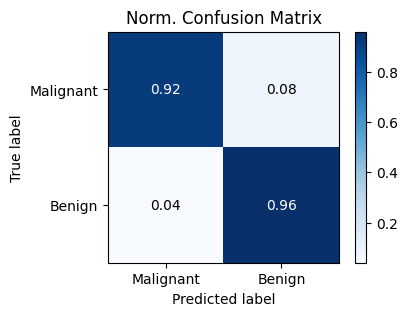

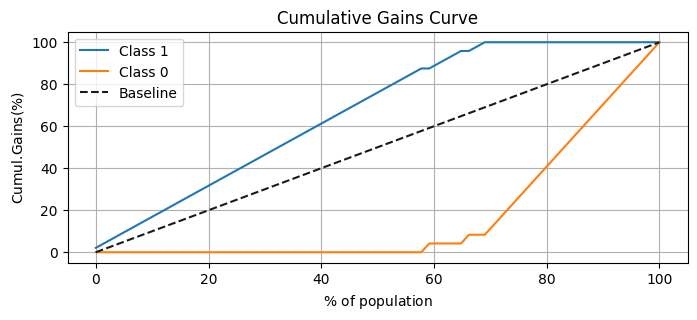

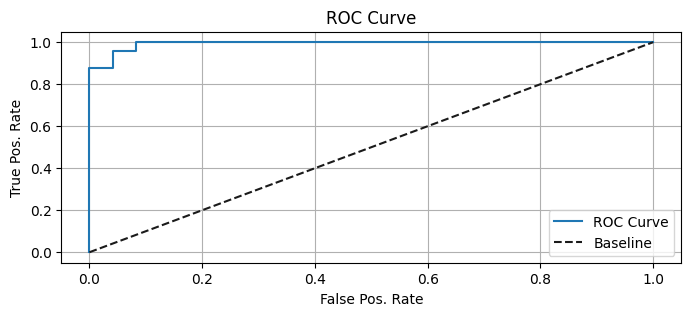

In [91]:
anp.random.seed(def_seed)

n_inputs,n_features = inputs_train_s.shape

layer_output_sizes = [10,5,1]

hidden_func  = sigmoid #sigmoid, ReLU, expReLU, LeakyReLU, identity, tanh
hidden_der = sigmoid_der #
#hidden_der = elementwise_grad(hidden_func)

act_funcs = []; act_ders = []
for i in range(len(layer_output_sizes)-1):
    act_funcs.append(hidden_func)
    act_ders.append(hidden_der)
act_funcs.append(sigmoid); 
output_der = sigmoid_der #elementwise_grad(act_funcs[-1]); 
#output_der = elementwise_grad(act_funcs[-1]); 
act_ders.append(output_der)

cost_func = log_loss
cost_der  = log_loss_der   #grad(cost_func,0) #log_loss_der #grad(cost_func,0)

network_cl = FFNNetwork(network_input_size=n_features,layer_output_size=layer_output_sizes,
                            activation_functions=act_funcs,activation_derivatives=act_ders,
                            cost_function=cost_func,cost_derivative=cost_der,random_state=def_seed)

network_cl.create_layers()

## Gradient Descent setup
eta = 3e-4
gamma = 1e-8
lmbda = 1e-10; lp = 2
decay = 0.9

batches = 128; epoch = 1000

## Calling the gradient descent (GD)-method
#GDMethod = PlainGD(eta,lmbda=lmbda,lp=lp)
#GDMethod = MomentumGD(eta,gamma,lmbda=lmbda,lp=lp)
#GDMethod = Adagrad(eta,gamma,lmbda,lp=lp)
GDMethod = RMSprop(eta,decay=decay)
#GDMethod = ADAM(eta,lmbda=lmbda)


network_cl.train_network(input=inputs_train_s,target=targets_train,GDMethod=GDMethod,
                                batches=batches,epochs=epoch)

final_prediction = network_cl.predict(inputs_test_s,binary=False)
final_prediction_bin = np.zeros_like(final_prediction)
for k in range(len(final_prediction)):
    if final_prediction[k] >= 0.5:
        final_prediction_bin[k] = 1

final_prediction_train = network_cl.predict(inputs_train_s,binary=False)
final_prediction_train_bin = np.zeros_like(final_prediction_train)
for k in range(len(final_prediction_train)):
    if final_prediction_train[k] >= 0.5:
        final_prediction_train_bin[k] = 1

acc = accuracy_score(targets_test,final_prediction_bin)
acc_train = accuracy_score(targets_train,final_prediction_train_bin)
print('(eta,lmbda)',eta,lmbda)
print('Prediction accuracy, test data    :',acc)
print('Prediction accuracy, training data:',acc_train)
print('Loss:',network_cl.cost(inputs_test_s,targets_test))
print('Loss:',log_loss(final_prediction,targets_test))


fig,bx = plt.subplots(1,1,figsize=(4,3))
bx.axis('off')
ax = confusion_roc_cumul_gains(targets_test,final_prediction[:,0],plots='all')
#fig.savefig('confusion_mat.png',dpi=300,bbox_inches='tight')
bx = ax[0][0]

In [72]:
fig.savefig('conf_matrix_rms.png',dpi=300,bbox_inches='tight')
ax[1][0].savefig('cumul_rms.png',dpi=300,bbox_inches='tight')
ax[2][0].savefig('roc_rms.png',dpi=300,bbox_inches='tight')